In [1]:
%load_ext autoreload
%autoreload 2.

In [2]:
import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import functools
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import torch
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

In [3]:
!nvidia-smi

Sun Jan 10 13:29:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   30C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   29C    P0    32W / 250W |   1827MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:1')

print(device)

cuda:0


In [5]:
import sys
sys.path.append('../')

# import utils 
from utils.viz_tools import plot_central_cuts
from data.data import LA5_Siblings_MRI, MriClassification
# from utils import routine

### 1. Defining dataset for structural data

#### We have four options to alayse the structural data:
- BIDS from the original sourse;
- FSL FAST sculltripped;
- FreeSurfer processed;
- fMRIprep processed.

In [6]:
# the first option
os.listdir('/home/datasets/LA5study/BIDS_LA5study/sub-11044/anat')

['sub-11044_T1w.nii.gz', 'sub-11044_T1w.json']

In [7]:
# the third option
os.listdir('/home/datasets/LA5study/LA5_freesurfer/sub-11044/mri');

In [8]:
# LA5_study_general
la5_data = ['/home/datasets/LA5study/fmriprep_LA5study_aroma/fmriprep/']
# la5_data = ['/home/datasets/LA5study/BIDS_LA5study/']
la5_temp_npy_folder_path = '../../LA5study_temp_npy/' # for numpy files
la5_target_path = '../data/LA5study_targets.csv'
#  LA5_study_smri
la5_smri_file_suffix = 'T1w_space-MNI152NLin2009cAsym_preproc.nii'
# la5_smri_file_suffix = '_T1w.nii.gz'
la5_smri_brain_mask_suffix = 'T1w_space-MNI152NLin2009cAsym_brainmask.nii'

In [9]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

LA5 absmax before normalization: 435.0126647949219
Dataset size: 175
Labels distribution: (array([0, 1]), array([125,  50]))

Example:
Image shape: (1, 153, 189, 163)
Target: 0


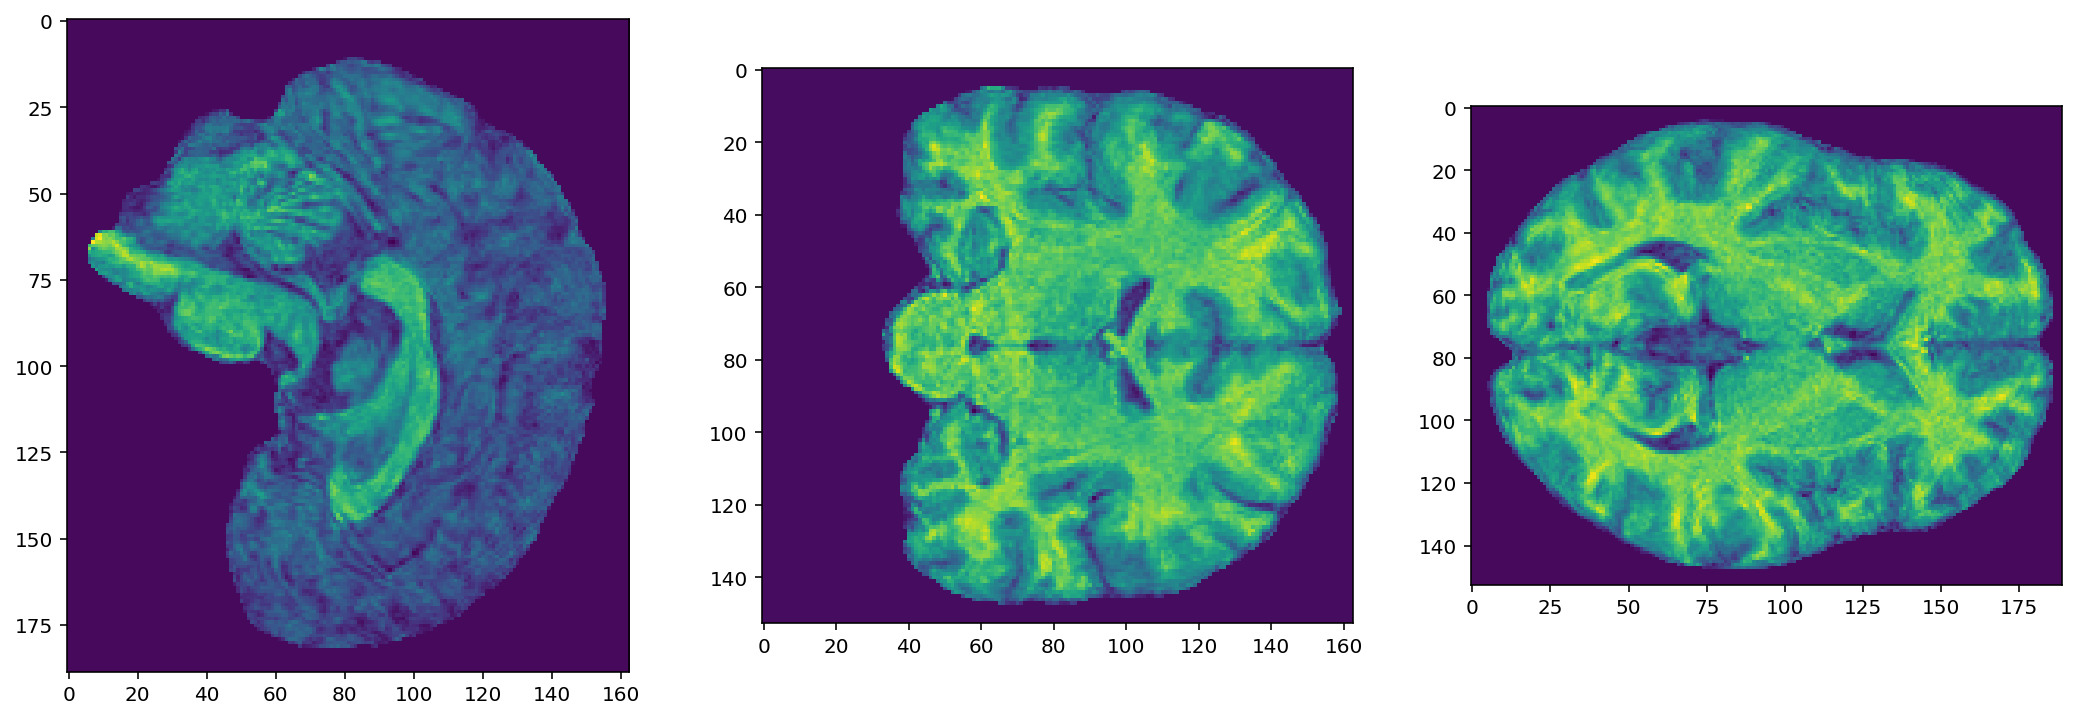

In [10]:
la5_dataset = LA5_Siblings_MRI(
    paths= la5_data,
    target_path= la5_target_path,
    load_online=True,
    mri_type="sMRI",
    mri_file_suffix= la5_smri_file_suffix,
    brain_mask_suffix= la5_smri_brain_mask_suffix,
    coord_min=(20,20,0),
    img_shape=(153, 189, 163),
    problems=['Schz/Control'],
    temp_storage_path= la5_temp_npy_folder_path
)
la5_absmax = 435.0126647949219 # get_absmax(la5_dataset)
la5_dataset.transform = functools.partial(AbsMaxScale, absmax=la5_absmax)
print("LA5 absmax before normalization: {}".format(la5_absmax))
print("Dataset size: {}".format(len(la5_dataset)))
print("Labels distribution: {}\n".format(np.unique(la5_dataset.labels, return_counts=True)))

print("Example:")
img, target = la5_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
plot_central_cuts(img)

# Model structure

In [11]:
import utils.models as models

def create_model_opt(model_load_path=None, transfer=False):
    # reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = models.VoxResNet(num_classes=2, n_filters=32, stride=2, n_blocks=4,
                             input_shape=la5_dataset.img_shape, dropout=0., n_fc_units=128,
                             n_flatten_units=23040)
    
#     model = torch.nn.Sequential(*(list(model.model[:-7]) + list([model.model[-7]]) + list(model.model[-7:])))
    

    if model_load_path is not None:
        model.load_state_dict(torch.load(model_load_path))  
    if transfer:
        for param in model.parameters():
            param.requires_grad = False
        
        last = torch.nn.Linear(128, 2)
        modules = list(list(model.children())[0].children())[:-1] + [last]
        model = torch.nn.Sequential(torch.nn.Sequential(*modules))
        
        opt = torch.optim.Adam(last.parameters(), lr=3e-5)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=3e-5)
    return model, opt

create_model_opt()[0]

VoxResNet(
  (model): Sequential(
    (conv3d_1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (batch_norm_1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_1): ReLU(inplace=True)
    (conv3d_2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (batch_norm_2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_2): ReLU(inplace=True)
    (conv3d_3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (block_1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affin

## 1. Control vs SCHZ/BIPOLAR/ADHD

#### fmriprep data, VoxResNet, img_size, lr=0.002

In [13]:
from utils.routine import cross_val_score

In [15]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = cross_val_score(create_model_opt, la5_dataset, cv, device, metric, batch_size=10, model_save_path='voxresnet_test.pth')
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

In [12]:
model = create_model_opt()[0]
model.load_state_dict(torch.load('voxresnet.pth', map_location=device))

<All keys matched successfully>

### Interpretation

In [15]:
class ResNetGrad(torch.nn.Module):
    def __init__(self, model):
        super(ResNetGrad, self).__init__()
        self.features = model.model[:-5]
        self.classifier = model.model[-5:]
        self.gradients = None
    
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
class GuidedBackprop():
    def __init__(self, model):
        self.model = model
    
    def guided_backprop(self, input, label):
        
        def hookfunc(module, gradInput, gradOutput):
            return tuple([(None if g is None else g.clamp(min=0)) for g in gradInput])
    
        input.requires_grad = True
        h = [0] * len(list(self.model.features) + list(self.model.classifier))
        for i, module in enumerate(list(self.model.features) + list(self.model.classifier)):
            if type(module) == torch.nn.ReLU:
                h[i] = module.register_backward_hook(hookfunc)

        self.model.eval()
        output = self.model(input)
        self.model.zero_grad()
        output[0][label].backward()
        grad = input.grad.data
        grad /= grad.max()
        return np.clip(grad.cpu().numpy(),0,1)

In [19]:
import torch.nn.functional as F
import copy
import sklearn

def get_masks(mod, image, mask_type='grad_cam', cl=0):
    model = copy.deepcopy(mod)
    model.eval()
    masks = []
    image = torch.tensor(image).unsqueeze(1).to(device)
    logit = model(image)
    if mask_type == 'grad_cam':
        logit[:,cl].backward()
        activation = model.get_activations(image).detach()
        act_grad  = model.get_activations_gradient()
        pool_act_grad = torch.mean(act_grad, dim=[2,3,4], keepdim=True)
        activation = activation * pool_act_grad
        heatmap = torch.sum(activation, dim=1)
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)
        heatmap = F.interpolate(heatmap.unsqueeze(0),(153, 189, 163), mode='trilinear', align_corners=False)
        masks.append(heatmap.cpu().numpy())
    elif mask_type == 'guided_backprop':
        gp = GuidedBackprop(model)
        pred = logit.data.max(1)[1].item()
        img_grad = gp.guided_backprop(image, pred)
        masks.append(img_grad)
    return np.concatenate(masks,axis=0).squeeze(axis=1)


def configure_mask(mask):
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    return mask

1


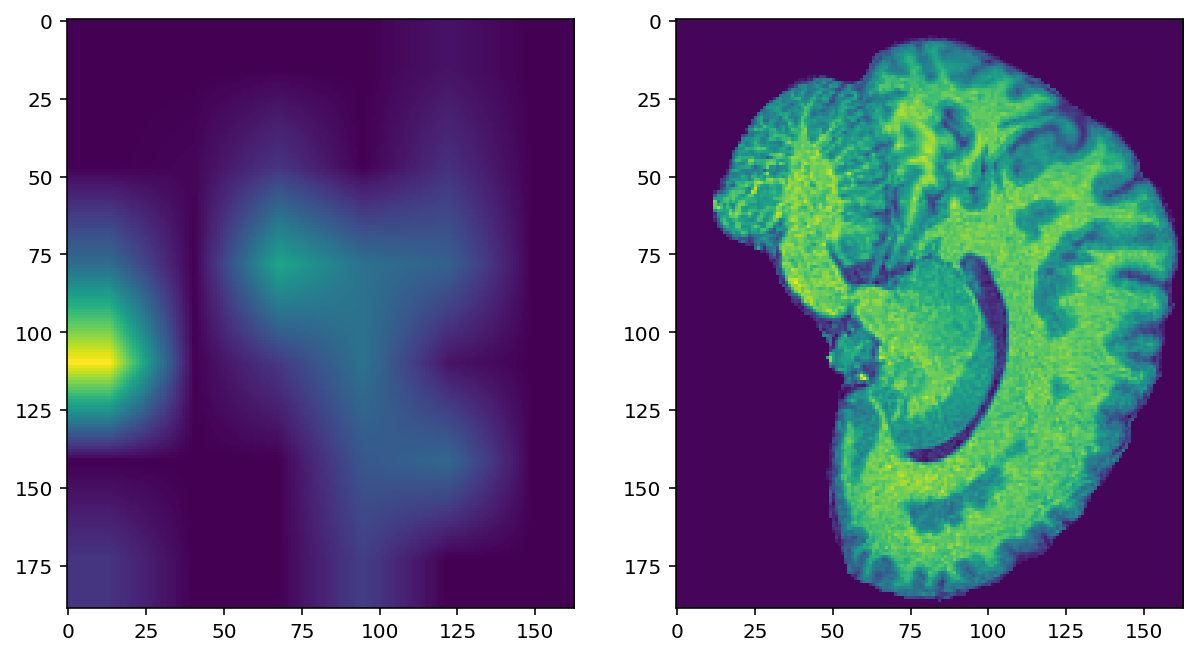

In [22]:
img_number = 151
masks = get_masks(ResNetGrad(model).to(device), la5_dataset[img_number][0], 'grad_cam')
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(masks[0][90])
plt.subplot(1, 2, 2)
plt.imshow(la5_dataset[img_number][0][0][90])
print(la5_dataset[img_number][1])

In [18]:
for img_number in range(len(la5_dataset)):
    masks = get_masks(ResNetGrad(model).to(device), la5_dataset[img_number][0], 'grad_cam')
    nib.save(nib.Nifti1Image(masks[0], affine=np.diag(np.ones(4)), header=nib.Nifti1Header()), 'saved_figures/grad_cam/' + str(img_number) + '.nii')

KeyboardInterrupt: 

1


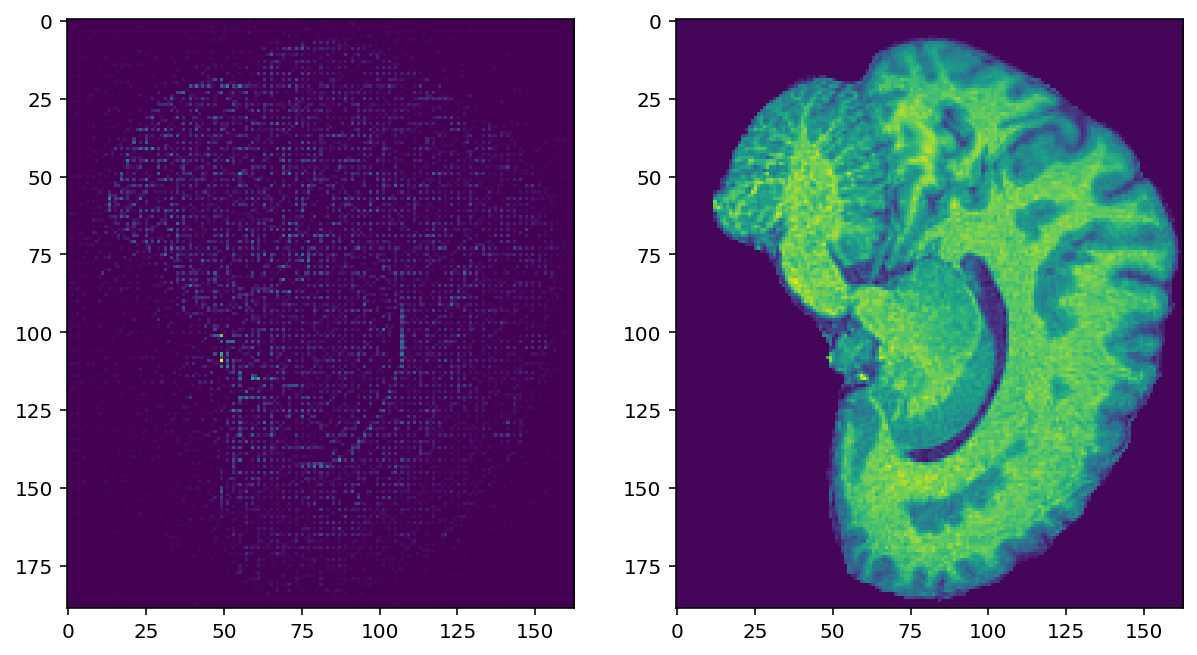

In [23]:
img_number = 151
gp_masks = get_masks(ResNetGrad(model).to(device), la5_dataset[img_number][0], 'guided_backprop')
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(configure_mask(gp_masks[0][90]))
plt.subplot(1, 2, 2)
plt.imshow(la5_dataset[img_number][0][0][90])
print(la5_dataset[img_number][1])

In [40]:
for img_number in range(len(la5_dataset)):
    masks = get_masks(ResNetGrad(model).to(device), la5_dataset[img_number][0], 'guided_backprop')
    nib.save(nib.Nifti1Image(masks[0], affine=np.diag(np.ones(4)), header=nib.Nifti1Header()), 'saved_figures/guided_backprop/' + str(img_number) + '.nii')

In [16]:
la5_dataset[img_number][0].shape

NameError: name 'img_number' is not defined

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

if torch.cuda.device_count() > 1:
    d_ids= [0, 1, 2]
    print("Let's use", d_ids, "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = torch.nn.DataParallel(model, device_ids=d_ids)
    model.to(f'cuda:0')

Let's use [0, 1, 2] GPUs!


In [14]:
device

device(type='cuda', index=0)

In [15]:
# X_la5 = torch.tensor(np.array([la5_dataset[i][0] for i in range(len(la5_dataset))]))
# preds = torch.tensor([la5_dataset[i][1] for i in range(len(la5_dataset))])
X_la5 = torch.tensor(np.array([la5_dataset[i][0] for i in range(10)]))
preds = torch.tensor([la5_dataset[i][1] for i in range(10)])

In [16]:
from meanpertrub import MeanPertrubFull

# device_ids = [0,1,2]
pertrub = MeanPertrubFull(device, rep=1)
masks_pertrub = pertrub.get_masks(X_la5, preds, model.to(device))

100%|██████████| 10/10 [00:00<00:00, 16.21it/s]


In [ ]:
from meanpertrub import MeanPertrub

# device_ids = [0,1,2]
pertrub = MeanPertrub(device, rep=1)
masks_pertrub = pertrub.get_masks(X_la5, preds, model.to(device))

  0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
X = np.array([la5_dataset[i][0] for i in range(len(la5_dataset))])
y = [la5_dataset[i][1] for i in range(len(la5_dataset))]

In [57]:
from meanpertrub import MeanPertrub

pertrub = MeanPertrub(device, rep=5)
masks_pertrub = pertrub.get_masks(X[:2], y[:2], model.to(device))

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 1; 15.90 GiB total capacity; 13.05 GiB already allocated; 4.38 MiB free; 13.32 GiB reserved in total by PyTorch)

In [32]:
X.shape

(175, 1, 153, 189, 163)

In [31]:
masks_pertrub.shape

(1, 1, 153, 189, 163)

0


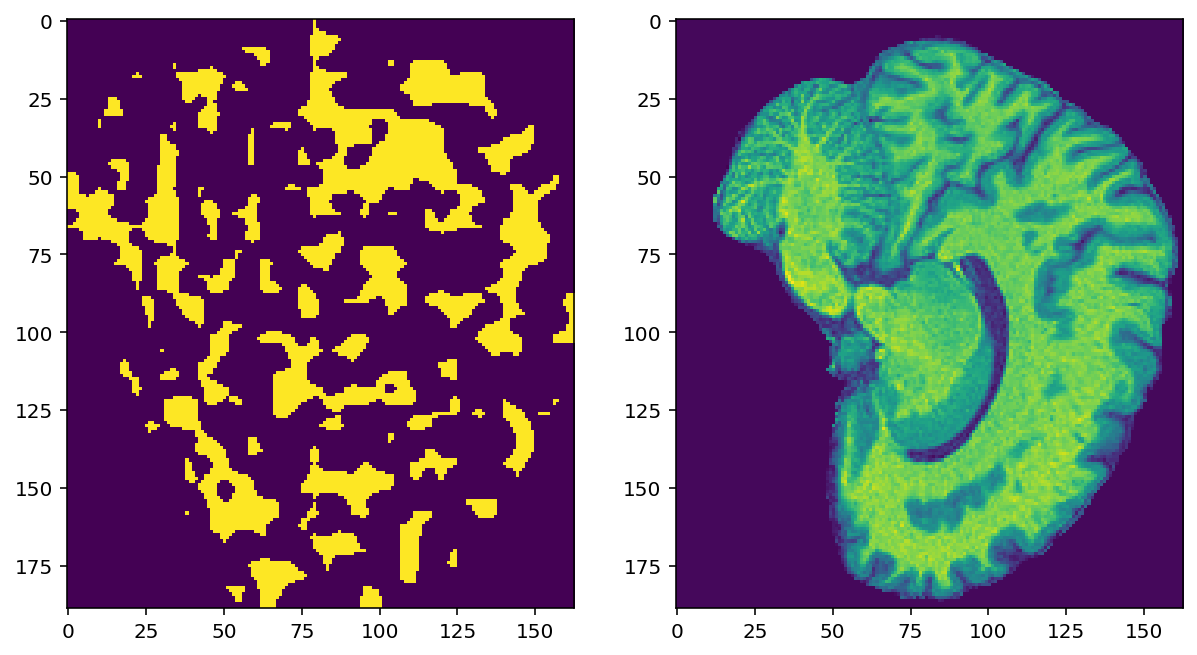

In [35]:
img_number = 10
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(masks_pertrub[0][0][90] >= 0.7)
plt.subplot(1, 2, 2)
plt.imshow(la5_dataset[img_number][0][0][90])
print(la5_dataset[img_number][1])

IndexError: index 90 is out of bounds for axis 0 with size 1

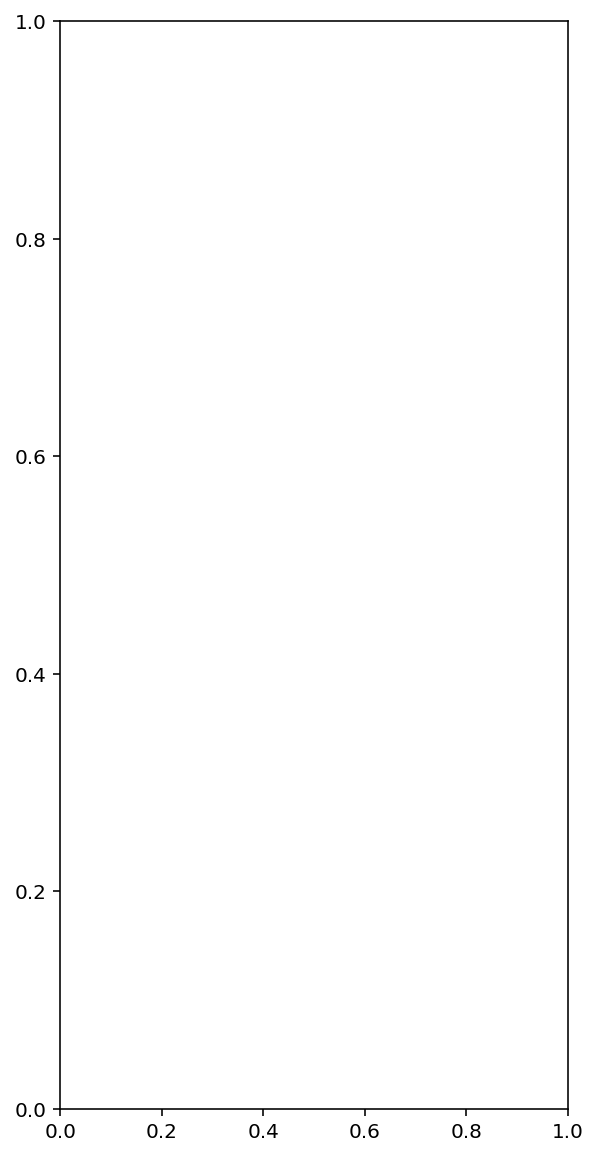

In [22]:
img_number = 10
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(configure_mask(np.array(masks_pertrub).mean(axis=0)[90] >= 0.5))
plt.subplot(1, 2, 2)
plt.imshow(la5_dataset[img_number][0][0][90])
print(la5_dataset[img_number][1])

In [51]:
for i, mask in zip(range(len(masks_pertrub)), masks_pertrub):
    nib.save(nib.Nifti1Image(mask, affine=np.diag(np.ones(4)), header=nib.Nifti1Header()), 'saved_figures/mean_pertrub/' + str(i) + '.nii')

In [104]:
mask = torch.tensor(configure_mask(np.array(masks_pertrub).mean(axis=0) >= 0.5)).to(device)

class ApplyMask(torch.nn.Module):
    
    def __init__(self, mask):
        super(ApplyMask, self).__init__()
        self.mask = mask.float()

    def forward(self, x):
        return torch.min(self.mask, x)


def create_model_opt(model_load_path=None, transfer=False):
    # reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = models.VoxResNet(num_classes=2, n_filters=32, stride=2, n_blocks=4,
                             input_shape=la5_dataset.img_shape, dropout=0., n_fc_units=128,
                             n_flatten_units=23040)
    
    
    model = torch.nn.Sequential(*([ApplyMask(mask)] + list(model.model)))
    

    if model_load_path is not None:
        model.load_state_dict(torch.load(model_load_path))  
    if transfer:
        for param in model.parameters():
            param.requires_grad = False
        
        last = torch.nn.Linear(128, 2)
        modules = list(list(model.children())[0].children())[:-1] + [last]
        model = torch.nn.Sequential(torch.nn.Sequential(*modules))
        
        opt = torch.optim.Adam(last.parameters(), lr=3e-5)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=3e-5)
    return model, opt

create_model_opt()[0]

Sequential(
  (0): ApplyMask()
  (1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (8): BasicBlock(
    (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (9): BasicBlock(
    (conv1): Conv3d(64, 64, kernel_size=(3,

In [131]:
import copy

la5_random = copy.copy(la5_dataset)
la5_random.labels = np.random.randint(2, size=len(la5_dataset.labels))

Epoch 10 of 10 took 40.952s
  training loss (in-iteration): 	0.265621
  validation loss: 			1.195665
  training roc_auc_score: 			0.99
  validation roc_auc_score: 			0.44


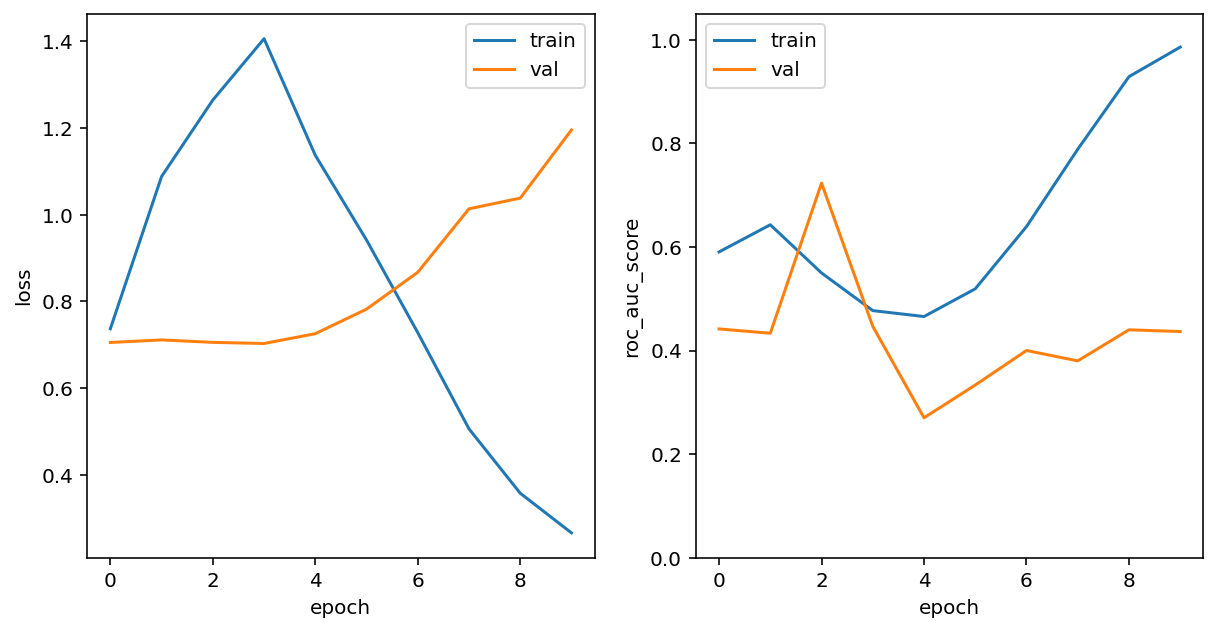

<Figure size 720x360 with 0 Axes>

val roc_auc_scores: [0.6633333333333333, 0.74, 0.5750000000000001, 0.7533333333333334, 0.7233333333333333]
val roc_auc_score mean: 0.6910000000000001
val roc_auc_score std: 0.06565566743752335


In [133]:
# 0.5 random test
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = cross_val_score(create_model_opt, la5_random, cv, device, metric, batch_size=10, model_save_path='voxresnet.pth')
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

Epoch 10 of 10 took 40.195s
  training loss (in-iteration): 	0.001886
  validation loss: 			0.664501
  training roc_auc_score: 			1.00
  validation roc_auc_score: 			0.82


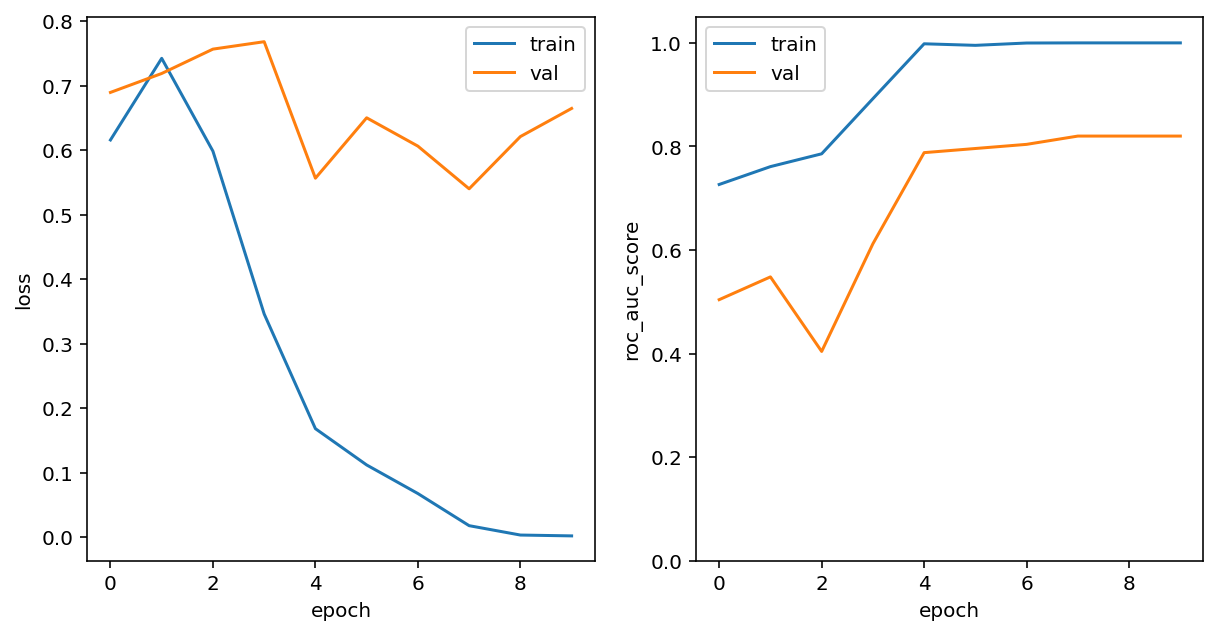

<Figure size 720x360 with 0 Axes>

Early stopping! Train loss < eps.
val roc_auc_scores: [0.8400000000000001, 0.844, 0.716, 0.7, 0.8200000000000001]
val roc_auc_score mean: 0.7840000000000001
val roc_auc_score std: 0.0627885339851155
CPU times: user 33min 37s, sys: 20min 42s, total: 54min 20s
Wall time: 31min 53s


In [96]:
# 0.46
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = cross_val_score(create_model_opt, la5_dataset, cv, device, metric, batch_size=10, model_save_path='voxresnet.pth')
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

Epoch 10 of 10 took 41.465s
  training loss (in-iteration): 	0.128827
  validation loss: 			0.911988
  training roc_auc_score: 			0.99
  validation roc_auc_score: 			0.84


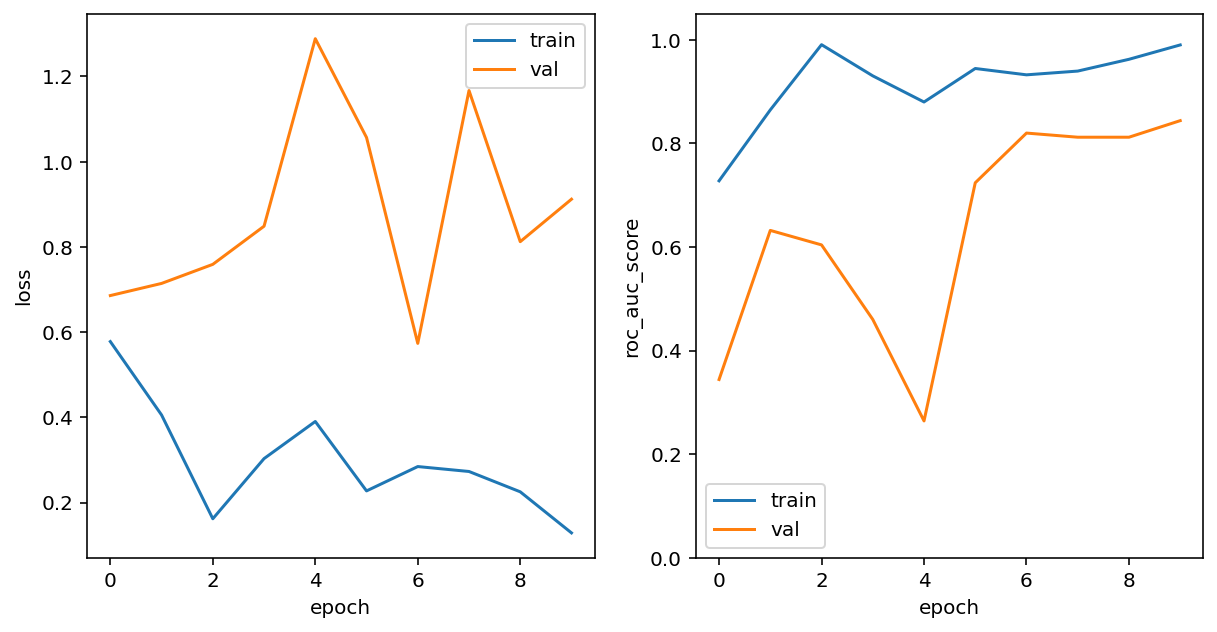

<Figure size 720x360 with 0 Axes>

val roc_auc_scores: [0.884, 0.9119999999999999, 0.6719999999999999, 0.7120000000000001, 0.844]
val roc_auc_score mean: 0.8048
val roc_auc_score std: 0.09544506273244309
CPU times: user 38min 46s, sys: 22min 28s, total: 1h 1min 15s
Wall time: 34min 28s


In [99]:
# 0.5
%%time
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = cross_val_score(create_model_opt, la5_dataset, cv, device, metric, batch_size=10, model_save_path='voxresnet.pth')
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

Epoch 6 of 10 took 39.893s
  training loss (in-iteration): 	0.002471
  validation loss: 			1.744788
  training roc_auc_score: 			1.00
  validation roc_auc_score: 			0.59


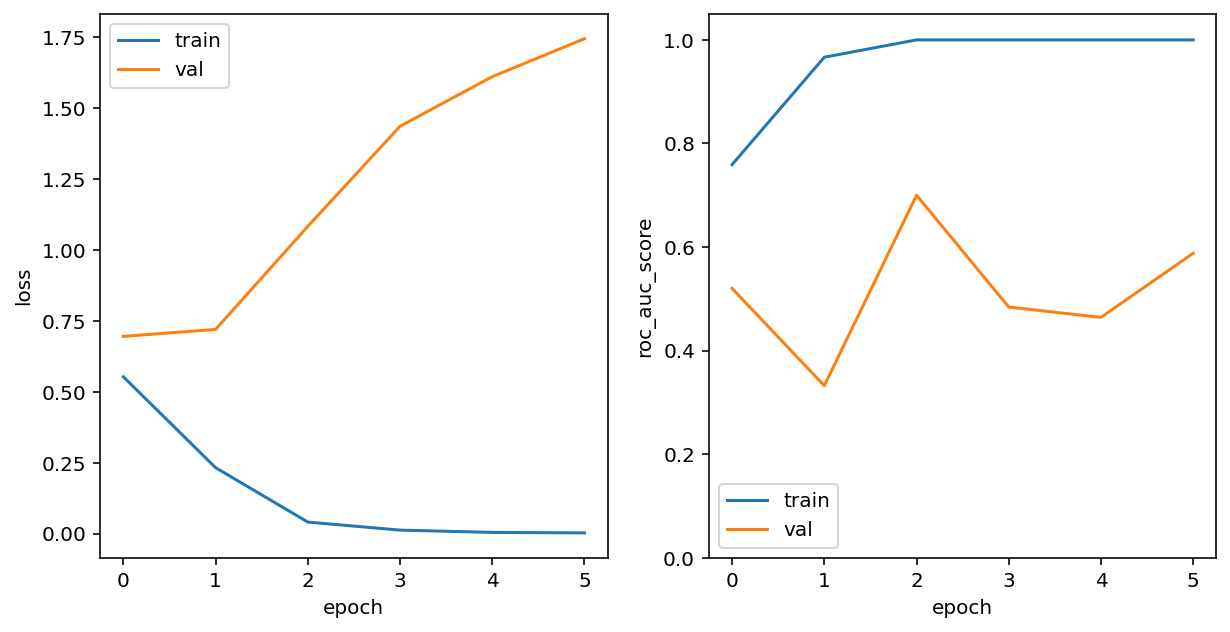

<Figure size 720x360 with 0 Axes>

Early stopping! Train loss < eps.
val roc_auc_scores: [0.66, 0.598, 0.52, 0.664, 0.7000000000000001]
val roc_auc_score mean: 0.6284000000000001
val roc_auc_score std: 0.063351716630254


In [102]:
# 0, проверка
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = cross_val_score(create_model_opt, la5_dataset, cv, device, metric, batch_size=10, model_save_path='voxresnet.pth')
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

In [74]:
from skimage.transform import resize

def get_regions_from_mask(mask, atlas_name='icbm', nb_best_regions=5,  verbose=False):
    if atlas_name == 'icbm':
        atlas = nibabel.Nifti1Image.from_filename('atlas/icbm/ICBM_WMPM.nii', mmap=False)
        atlas_data = atlas.get_fdata()
        labels = np.unique(atlas_data)
        nb_of_labels = len(labels)-1
        with open('atlas/icbm/LabelLookupTable.txt') as f:
            file = f.read()
        label_names = [None]*50
        for line in file.split('\n'):
            items = line.split('\t')
            if len(items) == 1:
                continue
            nb = int(items[0])
            region_name = items[-1]
            label_names[nb-1] = region_name
        label_names[-1] = 'Tapatum right'
    elif atlas_name == 'brainnet':
        atlas = nibabel.Nifti1Image.from_filename('brainnettome/BN_Atlas_246_1mm.nii.gz', mmap=False)
        atlas_data = atlas.get_fdata()
        labels = np.unique(atlas_data)
        nb_of_labels = len(labels)-1
        with open('atlas/brainnettome/BN_Atlas_246.txt') as f:
            file = f.read()
        label_names = file.split()
        
    resized_mask = resize(mask, atlas_data.shape)
    scores = [None]*nb_of_labels
    for i in range(1, nb_of_labels+1):
        region = atlas_data == i
        score = np.sum(resized_mask * region) / np.sum(region)
        scores[i-1] = score
        if verbose:
            print('{:>35} {:>10.2f}'.format(label_names[i-1][:30], score))
            
    scores = np.array(scores)
    scores = scores / np.sum(scores) #normalizing
    np_labels = np.array(label_names)
    
    return np_labels, scores

In [81]:
true_images = [la5_dataset[i][0] for i in range(len(la5_dataset)) if la5_dataset[i][1] == 1]
false_images = [la5_dataset[i][0] for i in range(len(la5_dataset)) if la5_dataset[i][1] == 0]

In [121]:
def mean_mask(model, images):
    masks = [get_masks(model, im, 'grad_cam') for im in images]
    return np.array(masks).mean(axis=0)[0]

true_mean = mean_mask(ResNetGrad(model).to(device), true_images)
false_mean = mean_mask(ResNetGrad(model).to(device), false_images)

In [153]:
def compute_dice(A, B, th=0.15):
    a = (A > th).astype(np.int_)
    b = (B > th).astype(np.int_)
    return 2 * ((a & b).astype(np.int_)).sum() / (a.sum() + b.sum())

In [155]:
compute_dice(true_mean, false_mean)

0.6164609744493885

In [156]:
compute_dice(true_mean, np.load('true_mean_bipolar.npy'))

0.5726077683608922

In [127]:
icbm_labels, true_icbm_scores = get_regions_from_mask(true_mean)
_, false_icbm_scores = get_regions_from_mask(false_mean)

df_icbm = pd.DataFrame()
df_icbm['Regions'] = icbm_labels
df_icbm['true'] = true_icbm_scores
df_icbm['false'] = false_icbm_scores

df_icbm

,Regions,true,false
0,Middle cerebellar peduncle,0.014344,0.014256
1,Pontine crossing tract (a part of MCP),0.017123,0.016672
2,Genu of corpus callosum,0.027018,0.024074
3,Body of corpus callosum,0.020689,0.020000
4,Splenium of corpus callosum,0.022188,0.021833
5,Fornix (column and body of fornix),0.026419,0.024108
6,Corticospinal tract right,0.017618,0.016698
7,Corticospinal tract left,0.018724,0.018392
8,Medial lemniscus right,0.013509,0.013521
9,Medial lemniscus left,0.014612,0.015127


In [321]:
#!pip install torchsummary
from torchsummary import summary

summary(model.to(device), (1, 153, 189, 163))